# ID2222 Data Mining, Homework 2
# **Discovery of Frequent Itemsets and Association Rules**

Brando Chiminelli, Tommaso Praturlon

November 21th, 2022

## Goal
The goal of this notebook is to find frequent itemsets, and to identify items that frequently occur together in sets of items, called baskets. By frequent items we mean products bought together by sufficiently many customers.
The second step is to find the so called "Association rules”. Those are if-then rules in the form of implication X → Y (if X then Y), where X and Y are itemsets (Y can be just an item) such that X∩Y=∅. For example: If butter and bread are bought together, customers also buy milk: {butter, bread} → {milk}. The rule needs the support of many (several hundred) transactions to be statistically significant.

In our dataset we are dealing with sales transactions (baskets) of hashed items, so our associations rules will be for example {125, 987} → {122}. Moreover, we will display the relative confidence for each association rule.

## How to run

In order to run this notebook you need to import the dataset from this address (https://canvas.kth.se/courses/36211/files/5772174/download?wrap=1) in a 'data/' directory.
Then you can run all the notebook and read along the descriptions of the different parts of the implementation and check the comments present on the code.

## Import libraries and read the dataset
In the following we import the few libraries needed for the project and we read the dataset.

We decided to read the first 2000 baskets from the dataset in order to reduce weight on memory. Our assumption is that items are uniformly distributed across the dataset, thus allowing us to have a good insight only from the given sample.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import statistics
import math

PATH_TO_DATA = "../data/T10I4D100K.dat"
df_market = pd.read_csv(PATH_TO_DATA, header=None)
print("Data read successfully!")
# Delete duplicates from the dataset in the columns title and text

# Reduce dataset size for computation overload (temporary)
df_market = df_market.iloc[0:20000]
print(df_market.head())
print("Number of baskets: ", len(df_market))

Data read successfully!
                                                   0
0  25 52 164 240 274 328 368 448 538 561 630 687 ...
1            39 120 124 205 401 581 704 814 825 834 
2                    35 249 674 712 733 759 854 950 
3            39 422 449 704 825 857 895 937 954 964 
4  15 229 262 283 294 352 381 708 738 766 853 883...
Number of baskets:  20000


## Data cleaning

Before proceeding on, we need to clean our data, so to have our dataset as lists of integers, which is easier to work with. The cleaning of the data is implemented in the following block.

In [7]:
# DATA CLEANING
# Make the dataframe a list of list integers
baskets_ls = []
# take all the baskets with their items, columns[0] is the only column we have in our dataframe
df_baskets = df_market[df_market.columns[0]]

for basket in df_baskets:
    basket = basket.split() # split the string of items
    basket_ls = [] # create the single basket as list
    for item in basket:
        item = int(item) # convert an item to int
        basket_ls.append(item) # add it to the basket
    baskets_ls.append(basket_ls) # add the basket to the list

# print(baskets_ls)

## A-Priori algorithm

To find frequent itemsets with support at least s in a dataset of sales transactions, we are implementing the A-Priori algorithm.

First we need to define the **support** of an itemset as the the number of transactions containing the itemset. We say a set I of items is frequent only if its support is at least the value of a threshold s. The threshold s of the support should be set sufficiently high that not so many frequent itemsets are together. As a rule of thumb, s is 1% of the number of baskets.

## Finding frequent items

The first pass of the A-Priori algorithm is to determine which are the frequent items as singletons. Thus creating a list of these frequent items (in the code called "items") hopefully smaller than the one with all the items.

C_1 is the **candidate** set for single items and is a dictionary with the key equal to the item and the value is its support.

Since for a candidate to be a frequent itemset, all its subsets must be frequent, we added a loop that removes from the candidate set the items that are not frequent, so that this new candidate set will be used to find the frequent doubletons, tripletons, etc..

In order to get results in a short time we set the threshold at the highest integer above the mean of the frequencies, in this case 2.

In [8]:
# items must have at least a frequence of support threshold 1% of total baskets
S_THRESHOLD = 0.01*len(baskets_ls)

# dictionary containing all frequencies for frequent items
C_1 = dict()
# take all the baskets with their items
# for every basket take the item and if it already exists
# in the dictionary count +1
for basket in baskets_ls:
    for item in basket:
        C_1[item] = C_1.get(item,0) + 1 # get gives the i value, if not found, gives 0
        
# find frequency statistics among items
min_freq = min(C_1.values())
max_freq = max(C_1.values())
mean_val = statistics.mean(C_1.values())
median = statistics.median(C_1.values())
#S_THRESHOLD = math.ceil(mean_val) # set the threshold to next int after mean

print("Minimum frequency: ", min_freq)
print("Maximum frequency: ", max_freq)
print("Median: ", median)
print("Mean: ", mean_val)
print("Support threshold [ceil(mean)]: ", S_THRESHOLD)
#S_THRESHOLD=20

# delete non-frequent items
for item in list(C_1): # c1 is a list of dictionaries (e.g. 1:6, where 1 (key) is the value and 6 (value) the counter)
    if C_1[item]<S_THRESHOLD:
        del C_1[item]

items = list(C_1.keys()) # list of all different frequent items
support = [C_1] # list of dictionaries
# print("Support for C_1: \n", support)
# print("List of frequent items:\n", items)
#print("C_1 items: ", len(items))

Minimum frequency:  1
Maximum frequency:  1580
Median:  160
Mean:  232.31645569620252
Support threshold [ceil(mean)]:  200.0


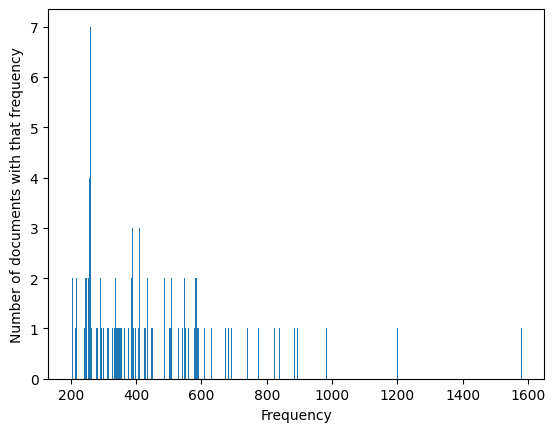

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

cnt = Counter(C_1.values())
plt.bar(cnt.keys(), cnt.values())

plt.xlabel('Frequency')
plt.ylabel('Number of documents with that frequency')
plt.show()

## Find the support of all frequent itemsets in our dataset

The second step of the algorithm is to count all the pairs that consist of two frequent items. At the end of this step, we examine the structure of counts to determine which pairs are frequent. The same steps are applied to find larger sets of frequent items.
For the Monotonicity Rule, we know that if no frequent itemsets of a certain size are found, there cannot be a larger itemset of them, therefore we can break the iteration.

In order to get results in a short time we are only considering intemsets of dimension 1, 2, 3.

In [11]:
# for every possible length of boundles, (a, b), (a, c, d), (e, f, g, w), ...
# ideally there is a number of Candidate Items Sets as big as the cardinality
# of all frequent singletons

for i in range(2,len(items)):
    s = dict() # new support, now for doubletons, tripletons, etc. 
    # for every combinations of i items
    # count frequency of every combination among all baskets
    for combo in combinations(items,i):
        # iterate again in every basket of the original dataframe
        for basket in baskets_ls:
            # if the combination of i items is found in the basket, count+1
            if set(combo).issubset(basket):
                s[combo] = s.get(combo,0) + 1
                # print("Found combo: ", combo)
        # once all baskets are checked
        # if there is a set for that combination and it is below threshold
        # delete it -> keep  only actually frequuent items
        # print("s.get(combo): ", s.get(combo))
        # print("s[combo]: ", s[combo])
        if s.get(combo) and s[combo]<S_THRESHOLD:
            #print("Deleted s[combo] ", s[combo])
            del s[combo]
    # if s is empty -> the dimension i of itemsets is not present in any basket
    if not s:
        break # exit the for cycle (monotonicity rule)
    support.append(s) # add the support of multiple-tons
    items = list(s.keys())
    new_items = []
    for i in range(len(items)):
        for j in range(len(items[i])):
            new_items.append(items[i][j])
    items = set(new_items)
    print("Items: ", items)

# Print list of all dictionaries for each combination with their frequencies
print(support)

KeyboardInterrupt: 

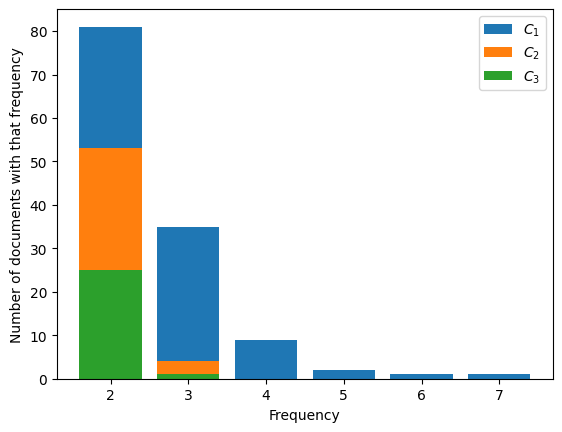

In [165]:
k = 0
for C_k in support:
    k+=1
    cnt = Counter(C_k.values())
    plt.bar(cnt.keys(), cnt.values(), label=fr"$C_{k}$")

plt.xlabel('Frequency')
plt.ylabel('Number of documents with that frequency')
plt.legend()
plt.show()

## Generating association rules 
In this final part we are generating association rules with confidence at least c = 50 from the itemsets found in the first step.

Confidence of rule X → Y is the fraction of transactions containing X⋃Y in all transactions that contain X, so we can say is the conditional probability of the itemset. A confidence set at 50 means that the probability of X⋃Y, given X, has to be at least 50%.

Moreover, since association rules are not symmetric, but we took combination that were only of the type (a,b) and not viceversa, now we need to test the rule X → Y and also Y → X for the same frequent combination.


In [166]:
MIN_CONFIDENCE = 50.0 # confidence is set to be at least 50% 
# (confidence is the conditional probability of the itemset)

rules = dict()
# start from the last element of support, so the biggest cardinality of combo
for combo in support[-1]: 
    for item in combo:
        c = list(combo) 
        c.remove(item) # we need to remove one item from the combo to test our rule
        len_c = len(c)
        # if we have to deal with tuple if our combo now has more than one element
        c = c[0] if len_c == 1 else tuple(c) 
        
        # now we compute the confidence that is:
        # the support of the union of the combo and the item divided by the support of the combo
        rule_1 = support[-1][combo]/support[0][item]*100 
        # we do the same with the opposite rule (rules are not symmetric)
        rule_2 = support[-1][combo]/support[len_c-1][c]*100 
        
        if rule_1>=MIN_CONFIDENCE: rules[f"{item}->{c}"] = rule_1
        if rule_2>=MIN_CONFIDENCE: rules[f"{c}->{item}"] = rule_2

print(rules)

{'25->(52, 730)': 100.0, '(52, 730)->25': 100.0, '52->(25, 730)': 66.66666666666666, '(25, 730)->52': 100.0, '730->(25, 52)': 100.0, '(25, 52)->730': 100.0, '368->(947, 296)': 50.0, '(947, 296)->368': 100.0, '947->(368, 296)': 66.66666666666666, '(368, 296)->947': 100.0, '(368, 947)->296': 100.0, '825->(39, 704)': 75.0, '(39, 704)->825': 100.0, '39->(825, 704)': 75.0, '(825, 704)->39': 100.0, '704->(825, 39)': 75.0, '(825, 39)->704': 100.0, '895->(334, 874)': 66.66666666666666, '(334, 874)->895': 100.0, '334->(895, 874)': 100.0, '(895, 874)->334': 100.0, '874->(895, 334)': 66.66666666666666, '(895, 334)->874': 100.0, '738->(70, 296)': 66.66666666666666, '(70, 296)->738': 100.0, '70->(738, 296)': 50.0, '(738, 296)->70': 100.0, '(738, 70)->296': 100.0, '71->(208, 279)': 66.66666666666666, '(208, 279)->71': 100.0, '208->(71, 279)': 100.0, '(71, 279)->208': 100.0, '279->(71, 208)': 66.66666666666666, '(71, 208)->279': 100.0, '192->(888, 487)': 66.66666666666666, '(888, 487)->192': 100.0, '

In [167]:
print("Average confidence (mean): ", statistics.mean(rules.values()))

Average confidence (mean):  92.51126126126125
